In [1]:
import pickle
import gensim
import numpy as np
import nltk
import re
import pandas as pd
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize,sent_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load dataset with selected sections

In [2]:
with open('sample_data_1.p', 'rb') as f:
    data_dict = pickle.load(f)

In [3]:
df_1 = pd.DataFrame({'Country': data_dict['Country'],
                  'Projected Year': data_dict['ProjectedYear'],
                  'Published Date': data_dict['PublishedDate'],
                  'Content': data_dict['Content']})

In [4]:
df_1['Published Year'] = df_1['Published Date'].apply(lambda t: t.year)

In [5]:
df_1 = df_1.loc[df_1['Content'].str.len() != 0]

In [6]:
df_1.head(5)

,Content,Country,Projected Year,Published Date,Published Year
0,INTERNATIONAL MONETARY FUNDUNITED STATES OF AM...,United States,1996,1995-10-03,1995
1,ContentsIII. The Real Effective Value of the U...,United States,1996,1995-10-03,1995
2,ContentsIV. Trends in the International Use of...,United States,1996,1995-10-03,1995
3,ContentsV. Capital Flows and Exchange Rate Vol...,United States,1996,1995-10-03,1995
4,ContentsVI. Asymmetries in the U.S. Output-Inf...,United States,1996,1995-10-03,1995


### Load dataset with manually selected paragraphs

In [7]:
df_2 = pd.read_excel('ArticleIV_sample.xlsx')

In [8]:
df_2.head(5)

,Country,Published Year,Content
0,USA,2003,The 2003 consultation took place against the b...
1,USA,2004,The 2004 consultation discussions took place a...
2,USA,2005,The U.S. expansion solidified during the past ...
3,USA,2006,The U.S. economy has continued to be an engine...
4,USA,2008,The economy has shown remarkable resilience to...


### Load dataset with full documents

In [9]:
with open('USA_processed_xml.p', 'rb') as f:
    US_data = pickle.load(f)

with open('UK_processed_xml.p', 'rb') as f:
    UK_data = pickle.load(f)

In [10]:
#Function to create a dataframe from a document object
def create_df_from_doc_obj(doc_obj):
    df = pd.DataFrame({'doc_seriesNo': doc_obj.series_id,
                       'doc_PublisherId': doc_obj.PublisherId,
                        'Country': doc_obj.country,
                         'Projected Year': doc_obj.ProjectedYear,
                        'Published Date': doc_obj.PublicationDate,
                        'Para_id': range(len(doc_obj.paras)),
                        'Paragraph': doc_obj.paras})
    df = df[['doc_seriesNo','doc_PublisherId','Country','Projected Year','Published Date','Para_id','Paragraph']]
    
    return df

In [11]:
US_df = pd.DataFrame()
for doc in US_data:
    df = create_df_from_doc_obj(US_data[doc])
    US_df = US_df.append(df)

UK_df = pd.DataFrame()
for doc in UK_data:
    df = create_df_from_doc_obj(UK_data[doc])
    UK_df = UK_df.append(df)
    
df_3 = pd.concat([US_df, UK_df])

## Try using a list of positive and negative vocabulary

1. Search negative and positive words in each paragraph of a document
2. Negate positive words within 3 words of negative words ('not','no','nobody','none','never','neither','cannot')
3. Do not negate negative words
4. Calculate a sentiment index by country and period:
        index = (#Positive words - #Negative words) / #Total words


Reference: 
Correa, Ricardo, Keshav Garud, Juan M. Londono, and
Nathan Mislang (2017). Sentiment in Central Banks’ Financial
Stability Reports. International Finance Discussion Papers 1203. 

In [12]:
sentiment_words = pd.read_csv('sentiment_words.csv')

In [13]:
pos_words = [word for word in sentiment_words.pos if isinstance(word, str) ]
neg_words = [word for word in sentiment_words.neg if isinstance(word, str) ]

pos_words_1 = ['\\b'+word+'\\b' for word in pos_words] #to find exact words
neg_words_1 = ['\\b'+word+'\\b' for word in neg_words]

pos_pattern = '|'.join(pos_words_1)
neg_pattern = '|'.join(neg_words_1)

In [14]:
df_1['No_pos_words'] = df_1.Content.apply(lambda para: len(re.findall(pos_pattern, para, flags=re.IGNORECASE)))
df_1['No_neg_words'] = df_1.Content.apply(lambda para: len(re.findall(neg_pattern, para, flags=re.IGNORECASE)))

df_2['No_pos_words'] = df_2.Content.apply(lambda para: len(re.findall(pos_pattern, para, flags=re.IGNORECASE)))
df_2['No_neg_words'] = df_2.Content.apply(lambda para: len(re.findall(neg_pattern, para, flags=re.IGNORECASE)))

df_3['No_pos_words'] = df_3.Paragraph.apply(lambda para: len(re.findall(pos_pattern, para, flags=re.IGNORECASE)))
df_3['No_neg_words'] = df_3.Paragraph.apply(lambda para: len(re.findall(neg_pattern, para, flags=re.IGNORECASE)))

In [15]:
from nltk.corpus import stopwords

negation_list = ['not','no','nobody','none','never','neither','cannot']

stopw = stopwords.words('english')
stopw = [s for s in stopw if s not in negation_list]
lemmatizer = WordNetLemmatizer()


#Function to get a list of 3 words before and after the keyword
def get_words_to_check_negation(words, idx, ran = 3):
    sent_length = len(words)
    nidx = [idx-ran, idx+ran]
    if nidx[0]<0: nidx[0]= 0
    if nidx[1] >sent_length+1: nidx[1] = sent_length+1
    negation_checklist = words[nidx[0]: nidx[1]]
    return negation_checklist


#Function to count number of positive words and negative words in a paragraph
def count_pos_neg_words(paragraph, negation_list):
    #1. Tokenize sentence:
    sent = sent_tokenize(paragraph)
    #2. Tokenize words in a sentence and calculate positive and negative words:
    pos = 0
    neg = 0
    for s in sent:
        words = word_tokenize(s.lower())
        for idx, w in enumerate(words):
            if w in pos_words:               
                negation_check = get_words_to_check_negation(words, idx, 3)
                list_negation = [t for t in negation_check if t in negation_list]
                if len(list_negation) == 0: pos+=1
                else: neg+=1
            elif w in neg_words:
                neg+=1
    return pos, neg

#Function to get the count of tokens in a paragraph
def count_number_of_tokens(paragraph, negation_list, lemmatizer, stopw):
    tokens = word_tokenize(paragraph.lower())
    tokens = [t for t in tokens if t.isalpha()] #to eliminate non characters
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t not in stopw]
    return len(tokens)

In [16]:
df_1['sentiment'] = df_1.Content.apply(lambda para: 
                                           count_pos_neg_words(para,negation_list))
df_1['total_tokens'] = df_1.Content.apply(lambda para: 
                                              count_number_of_tokens(para,negation_list, lemmatizer, stopw))
df_1[['sentiment_pos','sentiment_neg']] = df_1.sentiment.apply(pd.Series)


df_2['sentiment'] = df_2.Content.apply(lambda para: 
                                           count_pos_neg_words(para,negation_list))
df_2['total_tokens'] = df_2.Content.apply(lambda para: 
                                              count_number_of_tokens(para,negation_list, lemmatizer, stopw))
df_2[['sentiment_pos','sentiment_neg']] = df_2.sentiment.apply(pd.Series)


df_3['sentiment'] = df_3.Paragraph.apply(lambda para: 
                                           count_pos_neg_words(para,negation_list))
df_3['total_tokens'] = df_3.Paragraph.apply(lambda para: 
                                              count_number_of_tokens(para,negation_list, lemmatizer, stopw))
df_3[['sentiment_pos','sentiment_neg']] = df_3.sentiment.apply(pd.Series)

In [17]:
unique_df_1 = df_1.groupby(['Country','Published Year'], 
                             as_index = False)['sentiment_pos',
                                               'sentiment_neg',
                                                'total_tokens'].sum()

unique_df_1['sentiment_index'] = (unique_df_1.sentiment_pos - unique_df_1.sentiment_neg)/unique_df_1.total_tokens


df_2['sentiment_index'] = (df_2.sentiment_pos - df_2.sentiment_neg)/df_2.total_tokens

df_3['Published Year'] = df_3['Published Date'].apply(lambda t: t.year)
unique_df_3 = df_3.groupby(['Country','Published Year'], 
                             as_index = False)['sentiment_pos',
                                               'sentiment_neg',
                                                'total_tokens'].sum()

unique_df_3['sentiment_index'] = (unique_df_3.sentiment_pos - unique_df_3.sentiment_neg)/unique_df_3.total_tokens

In [18]:
unique_df_1.head(3)

,Country,Published Year,sentiment_pos,sentiment_neg,total_tokens,sentiment_index
0,United Kingdom,1996,258,318,25648,-0.002339
1,United Kingdom,1998,134,172,11288,-0.003366
2,United Kingdom,1999,75,108,6943,-0.004753


In [24]:
df_2.head(3)

,Country,Published Year,Content,No_pos_words,No_neg_words,sentiment,total_tokens,sentiment_pos,sentiment_neg,sentiment_index
0,USA,2003,The 2003 consultation took place against the b...,3,5,"(3, 5)",61,3,5,-0.032787
1,USA,2004,The 2004 consultation discussions took place a...,4,4,"(4, 4)",56,4,4,0.000000
2,USA,2005,The U.S. expansion solidified during the past ...,1,0,"(1, 0)",38,1,0,0.026316


In [19]:
unique_df_3.head(3)

,Country,Published Year,sentiment_pos,sentiment_neg,total_tokens,sentiment_index
0,United Kingdom,1996,304,323,26539,-0.000716
1,United Kingdom,1998,139,155,10311,-0.001552
2,United Kingdom,1999,104,146,9791,-0.004290


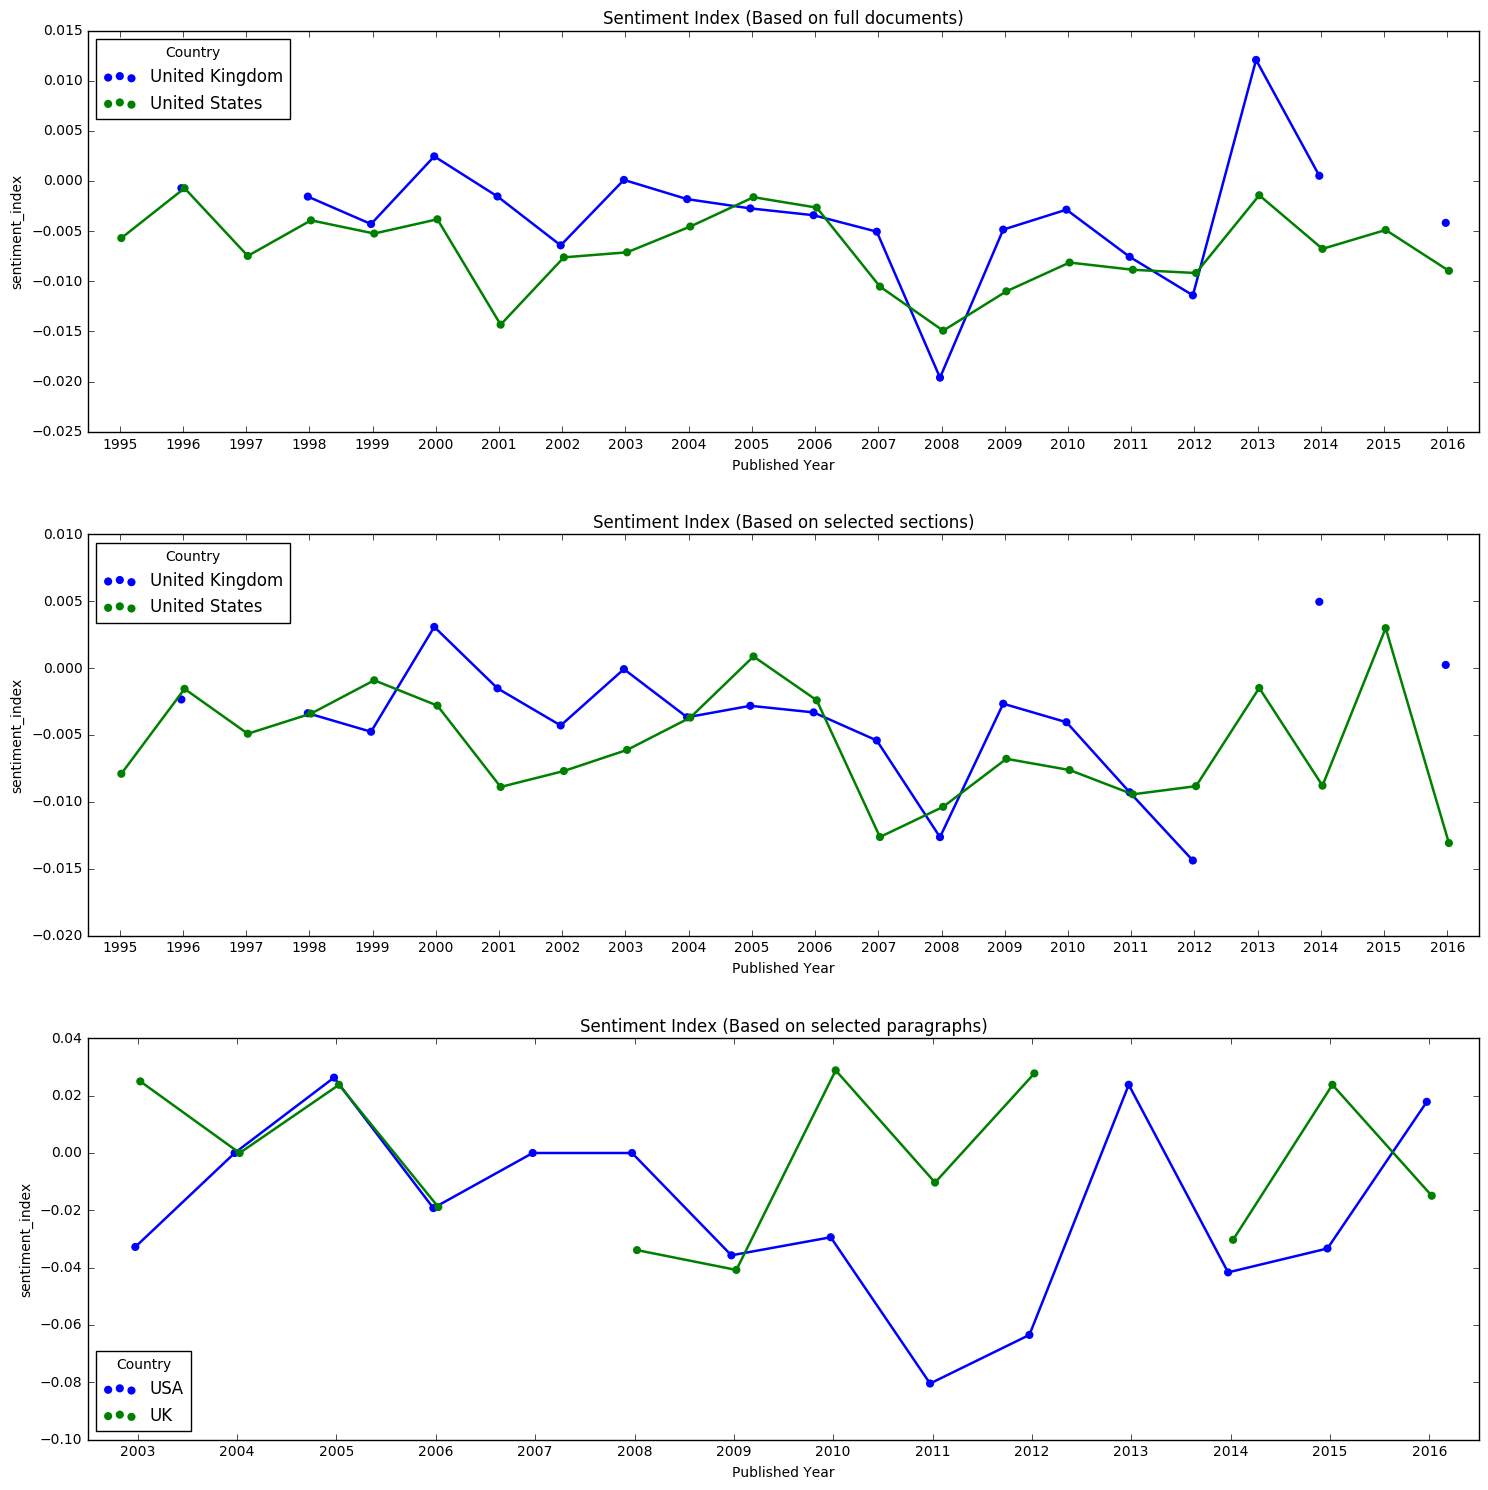

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

sns.pointplot(y = 'sentiment_index', x= 'Published Year',hue = 'Country', data = unique_df_3, dodge=True, ax = ax1)
sns.pointplot(y = 'sentiment_index', x= 'Published Year',hue = 'Country', data = unique_df_1, dodge=True, ax = ax2)
sns.pointplot(y = 'sentiment_index', x= 'Published Year',hue = 'Country', data = df_2, dodge=True, ax = ax3)

ax1.set_title('Sentiment Index (Based on full documents)')
ax2.set_title('Sentiment Index (Based on selected sections)')
ax3.set_title('Sentiment Index (Based on selected paragraphs)')

plt.tight_layout(h_pad=3,w_pad =3)

### Compare with GDP Growth



In [21]:
from IPython.display import HTML
HTML('''<iframe src="https://data.worldbank.org/share/widget?end=2016&indicators=NY.GDP.MKTP.KD.ZG&locations=US-GB&start=1994" width='700' height='466' frameBorder='0' scrolling="no" ></iframe>''')

## Apply Machine Learning
### Use financial news training dataset

In [22]:
labeled_news = pd.read_csv('Full-Economic-News-DFE-839861.csv',encoding = 'ISO-8859-1')
train_data1 = labeled_news.loc[labeled_news.relevance == 'yes']
train_data1 = train_data1[['text','positivity','positivity:confidence']]

labeled_news1 = pd.read_csv('us-economic-newspaper.csv',encoding = 'ISO-8859-1')
train_data2 = labeled_news1.loc[labeled_news1.relevance == 'yes']
train_data2 = train_data2[['text','positivity','positivity:confidence']]

train_data = pd.concat([train_data1, train_data2])
train_data.head()

,text,positivity,positivity:confidence
0,NEW YORK -- Yields on most certificates of dep...,3.0,0.6400
4,NEW YORK -- Indecision marked the dollar's ton...,3.0,0.3257
5,"Stocks declined, as investors weighed slower-t...",3.0,0.6783
9,The U.S. dollar declined against most major fo...,4.0,0.6657
12,Author: James B. Stewart</br></br>The dreaded ...,4.0,0.3388


In [23]:
# Drop missing values
train_data.dropna(inplace=True)
print (train_data.shape)

# Remove any 'neutral' ratings equal to 5
train_data = train_data.loc[train_data['positivity'] != 5]

# Encode 6-9s as 1 (rated positively)
# Encode 1-4s as 0 (rated poorly)
train_data['Positively Rated'] = np.where(train_data['positivity'] > 5, 1, 0)
train_data.head(3)

(4319, 3)


,text,positivity,positivity:confidence,Positively Rated
0,NEW YORK -- Yields on most certificates of dep...,3.0,0.6400,0
4,NEW YORK -- Indecision marked the dollar's ton...,3.0,0.3257,0
5,"Stocks declined, as investors weighed slower-t...",3.0,0.6783,0


In [24]:
def process_text( raw_news, lemmatizer, stopw ):
    '''
    Function to convert a raw news to a string of words
    The input is a single string (a raw news), and 
    the output is a single string (a preprocessed news)
    '''
    from bs4 import BeautifulSoup  
    
    # Remove HTML
    news_text = BeautifulSoup(raw_news,"lxml").get_text() 

    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", news_text) 
    # Tokenize and clean bag of words:
    tokens = word_tokenize(letters_only.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t not in stopw]
    tokens = [t for t in tokens if len(t)>1]
    
    return( " ".join( tokens ))   

In [25]:
train_data['processed_text'] = train_data['text'].apply(lambda t: process_text(t, lemmatizer, stopw))

train_data.head(3)

,text,positivity,positivity:confidence,Positively Rated,processed_text
0,NEW YORK -- Yields on most certificates of dep...,3.0,0.6400,0,new york yield certificate deposit offered maj...
4,NEW YORK -- Indecision marked the dollar's ton...,3.0,0.3257,0,new york indecision marked dollar tone trader ...
5,"Stocks declined, as investors weighed slower-t...",3.0,0.6783,0,stock declined investor weighed slower expecte...


In [26]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_data['processed_text'], 
                                                    train_data['Positively Rated'], 
                                                    random_state=4)



In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df=5).fit(X_train)
print ('Number of features:',len(vect.get_feature_names()))

X_train_vectorized = vect.transform(X_train)

Number of features: 3375


/Users/Hailey/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [64]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

clf = SVC(kernel='linear', C = 1, gamma = 0.001)
clf.fit(X_train_vectorized, y_train)

predictions = clf.predict(vect.transform(X_test))
preds_train = clf.predict(X_train_vectorized)

print('Accuracy (test set): {:.2f}'.format(accuracy_score(y_test, predictions)))
print ('Accuracy (training set): {:.2f}'.format(accuracy_score(y_train, preds_train)))
print('Test error: {0:.0f}%'.format((1 - accuracy_score(y_test, predictions))*100))
print ('Training error: {0:.0f}%'.format((1 - accuracy_score(y_train, preds_train))*100))

/Users/Hailey/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Accuracy (test set): 0.69
Accuracy (training set): 0.86
Test error: 31%
Training error: 14%


- There is a huge variance problem => would need to get more training data or using regularization methods 
- Potentially label some sentences/paragraphs in the Article IV and mix with financial news dataset to reduce mis-match data problem and increase training set

In [82]:
#use all financial news data to train model:
vect_full = TfidfVectorizer(min_df=5).fit(train_data['processed_text'])
X_train_vectorized_full = vect_full.transform(train_data['processed_text'])
y_train_full = train_data['Positively Rated']
clf_full = SVC(kernel='linear',C = 1, gamma = 0.001)
clf_full.fit(X_train_vectorized_full, y_train_full )

preds_train_full = clf_full.predict(X_train_vectorized_full)

print ('Training Error: {0:.2f}%'.format((1 - accuracy_score(y_train_full, preds_train_full))*100))


/Users/Hailey/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Training Error: 14.11%


In [29]:
#Use the train model to predict article IV dataset:

df_1['processed_text'] = df_1['Content'].apply(lambda t: process_text(t, lemmatizer, stopw))
df_2['processed_text'] = df_2['Content'].apply(lambda t: process_text(t, lemmatizer, stopw))
df_3['processed_text'] = df_3['Paragraph'].apply(lambda t: process_text(t, lemmatizer, stopw))



In [89]:
df_1['predicted_sentiment'] = clf_full.predict(vect_full.transform(df_1['processed_text']))
#df_2['predicted_sentiment'] = clf.predict(vect.transform(df_2['processed_text']))
#df_3['predicted_sentiment'] = clf.predict(vect.transform(df_3['processed_text']))


/Users/Hailey/anaconda/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [90]:
unique_df_1_ml = df_1.groupby(['Country','Published Year'], 
                             as_index = False)['predicted_sentiment'].sum()
unique_df_1_ml_1 = df_1.groupby(['Country','Published Year'], 
                             as_index = False)['processed_text'].count()
unique_df_1_ml['no_of_text'] = unique_df_1_ml_1['processed_text']
unique_df_1_ml['sentiment_index_ml'] = unique_df_1_ml['predicted_sentiment']/unique_df_1_ml['no_of_text']

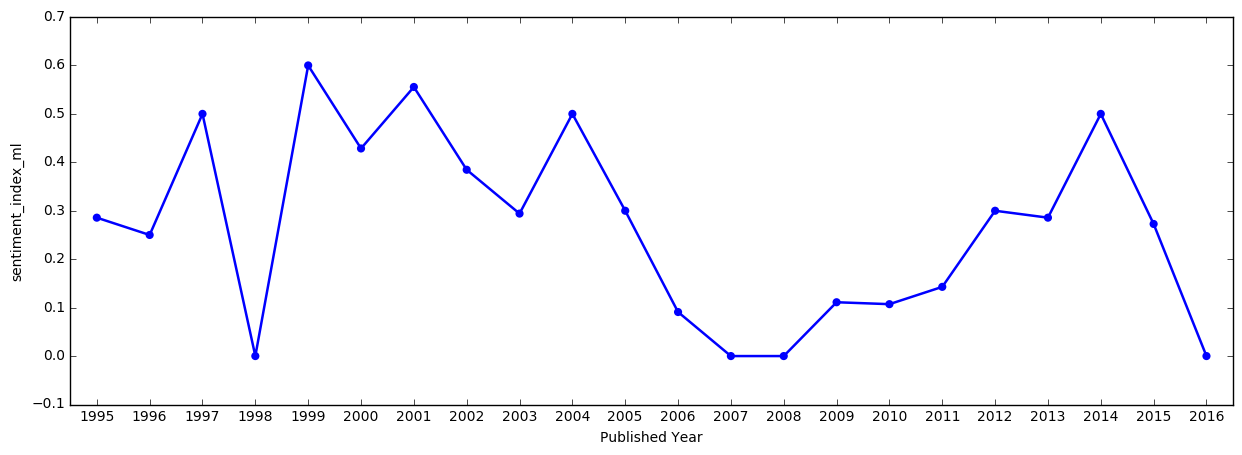

In [91]:
f, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
sns.pointplot(y = 'sentiment_index_ml', x= 'Published Year', data = unique_df_1_ml.loc[unique_df_1_ml.Country =='United States'], dodge=True, ax= ax1)

In [80]:
us_gdpgrowth = pd.read_excel('us_gdpgrowth.xlsx')
us_gdpgrowth = us_gdpgrowth.loc[us_gdpgrowth['Year']>1994]

In [108]:
import plotly.plotly as py
import plotly.graph_objs as go

data = unique_df_1_ml.loc[unique_df_1_ml.Country =='United States']
trace0 = go.Scatter(
    x = us_gdpgrowth.Year,
    y = us_gdpgrowth['GDP growth (annual %)'],
    mode = 'lines+markers',
    name = 'GDP growth'
)
trace1 = go.Scatter(
    x = data['Published Year'],
    y = data['sentiment_index_ml'],
    mode = 'lines+markers',
    name = 'Sentiment Index',
    yaxis='y2'
)

all_data = [trace0, trace1]

layout = go.Layout(
    title='Sentiment Analysis for USA - Machine Learning Approach',
    yaxis=dict(
        title='Annual %',
        range = [-4,6],
        zeroline=False
    ),
    yaxis2=dict(
        title='Sentiment Score',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right',
        range = [-0.5,1],
        zeroline=False
    ))
fig = go.Figure(data=all_data, layout=layout)
py.iplot(fig, filename='sentiment')
